## **OM\_perf — Overall Performance Metric**

We define the average performance of a KD method across **5 student models** and **4 evaluation tasks**:

$$
\text{OM\_perf}
=
\frac{1}{N_{\text{models}}}
\sum_{i=1}^{N_{\text{models}}}
\left(
    \frac{1}{T}
    \sum_{t=1}^{T}
    \frac{s_{i,t}}{s^{(\text{teacher})}_t}
\right)
$$

**Where:**

- $T = 4$
- $N_{\text{models}} = 5$
- $s_{i,t}$ = score of student model $i$ on task $t$
- $s^{(\text{teacher})}_t$ = teacher model score on task $t$


In [2]:
import json
import glob
from pathlib import Path
import numpy as np

# ------------------------------------------------------------------
# CONFIG: which metric to use for each task, and from where in JSON
# ------------------------------------------------------------------
# In the JSON:
# - arc_challenge:      results["arc_challenge"]["acc,none"]
# - hellaswag:          results["hellaswag"]["acc,none"]
# - bbh (group):        groups["bbh"]["exact_match,get-answer"]
# - mmlu (group):       groups["mmlu"]["acc,none"]
TASKS = ["arc_challenge", "hellaswag", "bbh", "mmlu"]

METRIC_CONFIG = {
    "arc_challenge": ("results", "acc,none"),
    "hellaswag":     ("results", "acc,none"),
    "bbh":           ("groups",  "exact_match,get-answer"),
    "mmlu":          ("groups",  "acc,none"),
}

def load_json(path):
    path = Path(path)
    with path.open("r") as f:
        return json.load(f)

def extract_task_scores(eval_json_path, tasks=TASKS, metric_cfg=METRIC_CONFIG):
    """
    Return a dict: {task_name: score} for the given eval json.
    """
    data = load_json(eval_json_path)
    scores = {}
    for task in tasks:
        section_name, metric_key = metric_cfg[task]
        section = data[section_name]
        scores[task] = section[task][metric_key]
    return scores


In [4]:
# ------------------------------------------------------------------
# PATHS you need to customize:
# ------------------------------------------------------------------
from pathlib import Path
import glob
import pandas as pd
import numpy as np

# 1) Single TEACHER eval JSON (used as the baseline for all KD types)
TEACHER_EVAL = "../../Base/eval/results/harness_meta-llama_Llama-3.1-70B-Instruct_20251113_144303_2025-11-14T01-20-58.355548.json"

# 2) All KD eval JSONs for each KD method
#    Put a glob pattern for each KD folder. You can rename the keys if you like.
KD_GLOBS = {
    # "feature":  "../../results/feature/*.json",   # feature-based KD
    "response": "../../results/response/*.json",  # response-based KD
    "relation": "../../results/relation/*.json",  # relation-based KD
}

print("KD patterns:")
for name, pattern in KD_GLOBS.items():
    print(f"  {name:9s} -> {pattern}")

# ------------------------------------------------------------------
# 1. Load teacher scores once
# ------------------------------------------------------------------
teacher_scores = extract_task_scores(TEACHER_EVAL, tasks=TASKS, metric_cfg=METRIC_CONFIG)
print("\nTeacher scores:")
for t in TASKS:
    print(f"  {t:14s}: {teacher_scores[t]:.4f}")

# ------------------------------------------------------------------
# 2. Helper to compute OM_perf for a single KD type
# ------------------------------------------------------------------
def compute_omperf_for_kd(glob_pattern, kd_label, teacher_scores, tasks=TASKS):
    """
    Given a glob pattern and label, load all eval JSONs, compute per-model OM_perf
    and the average OM_perf across models.
    """
    paths = sorted(glob.glob(glob_pattern))
    if not paths:
        print(f"WARNING: No files found for KD type '{kd_label}' with pattern: {glob_pattern}")
        return [], [], [], np.nan

    print(f"\n====================== KD type: {kd_label} ======================")
    print("Files:")
    for p in paths:
        print(" -", p)

    kd_models_scores = []
    om_perf_per_model = []

    # Load scores for each model
    for p in paths:
        scores = extract_task_scores(p, tasks=tasks, metric_cfg=METRIC_CONFIG)
        kd_models_scores.append((p, scores))

    # Compute OM_perf for each model
    for path, scores in kd_models_scores:
        ratios = []
        for t in tasks:
            s_kd = scores[t]
            s_teacher = teacher_scores[t]
            ratios.append(s_kd / s_teacher)
        om_model = sum(ratios) / len(tasks)  # average over tasks
        om_perf_per_model.append(om_model)
        print(f"OM_perf for model {Path(path).name}: {om_model:.4f}")

    om_perf_overall = float(np.mean(om_perf_per_model))
    print("----------------------------------------------------------------")
    print(f"Average OM_perf for KD type '{kd_label}' (avg over {len(om_perf_per_model)} models): {om_perf_overall:.4f}")
    print("----------------------------------------------------------------")

    return paths, kd_models_scores, om_perf_per_model, om_perf_overall

# ------------------------------------------------------------------
# 3. Loop over all KD types and build two DataFrames:
#    - df_models  : one row per (KD_type, model)
#    - df_summary : one row per KD_type with the average OM_perf
# ------------------------------------------------------------------
rows_models = []
rows_summary = []

for kd_label, pattern in KD_GLOBS.items():
    paths, kd_models_scores, om_vals, om_overall = compute_omperf_for_kd(
        glob_pattern=pattern,
        kd_label=kd_label,
        teacher_scores=teacher_scores,
        tasks=TASKS,
    )

    # Per-model rows
    for (path, scores), om_val in zip(kd_models_scores, om_vals):
        row = {
            "KD_type":    kd_label,
            "model_json": Path(path).name,
            "OM_perf":    om_val,
        }
        # also store raw task scores + ratios if you want
        for t in TASKS:
            row[f"{t}_score"] = scores[t]
            row[f"{t}_ratio"] = scores[t] / teacher_scores[t]
        rows_models.append(row)

    # One summary row per KD type
    rows_summary.append({
        "KD_type":      kd_label,
        "OM_perf_avg":  om_overall,
        "n_models":     len(om_vals),
    })

df_models  = pd.DataFrame(rows_models)
df_summary = pd.DataFrame(rows_summary)

print("\n====================== Per-model OM_perf ======================")
display(df_models)

print("\n====================== Per-KD OM_perf summary =================")
display(df_summary)


KD patterns:
  response  -> ../../results/response/*.json
  relation  -> ../../results/relation/*.json

Teacher scores:
  arc_challenge : 0.6195
  hellaswag     : 0.6347
  bbh           : 0.3583
  mmlu          : 0.8060

====================== KD type: response ======================
Files:
 - ../../results/response/23813_harness_meta-llama_Llama-3.1-8B-Instruct__20251114_0121_RB_1n_20251124_074507_2025-11-24T21-14-04.366143.json
 - ../../results/response/23814_harness_meta-llama_Llama-3.1-8B-Instruct__20251114_0130_RB_1n_20251124_074507_2025-11-24T20-58-13.395950.json
 - ../../results/response/23815_harness_meta-llama_Llama-3.1-8B-Instruct__20251114_0141_RB_1n_20251124_074507_2025-11-24T20-43-33.035850.json
 - ../../results/response/23816_harness_meta-llama_Llama-3.1-8B-Instruct__20251114_0151_RB_1n_20251124_074507_2025-11-24T21-12-27.982080.json
 - ../../results/response/23817_harness_meta-llama_Llama-3.1-8B-Instruct__20251114_0202_RB_1n_20251124_074507_2025-11-24T21-02-35.631355.jso

,KD_type,model_json,OM_perf,arc_challenge_score,arc_challenge_ratio,hellaswag_score,hellaswag_ratio,bbh_score,bbh_ratio,mmlu_score,mmlu_ratio
0,response,23813_harness_meta-llama_Llama-3.1-8B-Instruct...,1.098260,0.529863,0.855372,0.577176,0.909319,0.662264,1.848264,0.628757,0.780085
1,response,23814_harness_meta-llama_Llama-3.1-8B-Instruct...,1.099567,0.519625,0.838843,0.576877,0.908848,0.673015,1.878268,0.622490,0.772310
2,response,23815_harness_meta-llama_Llama-3.1-8B-Instruct...,1.103265,0.532423,0.859504,0.575284,0.906338,0.669943,1.869696,0.626691,0.777523
3,response,23816_harness_meta-llama_Llama-3.1-8B-Instruct...,1.103451,0.524744,0.847107,0.576479,0.908221,0.670558,1.871410,0.634383,0.787065
4,response,23817_harness_meta-llama_Llama-3.1-8B-Instruct...,1.106086,0.531570,0.858127,0.578470,0.911359,0.668407,1.865409,0.636305,0.789450
5,relation,23797_harness_meta-llama_Llama-3.1-8B-Instruct...,1.094604,0.522184,0.842975,0.571201,0.899906,0.656735,1.832833,0.646988,0.802704
6,relation,23798_harness_meta-llama_Llama-3.1-8B-Instruct...,1.105280,0.519625,0.838843,0.569508,0.897239,0.680233,1.898414,0.634026,0.786623
7,relation,23799_harness_meta-llama_Llama-3.1-8B-Instruct...,1.094018,0.518771,0.837466,0.570106,0.898180,0.662571,1.849121,0.637801,0.791306
8,relation,23800_harness_meta-llama_Llama-3.1-8B-Instruct...,1.085005,0.517065,0.834711,0.564429,0.889238,0.657042,1.833691,0.630608,0.782382
9,relation,23801_harness_meta-llama_Llama-3.1-8B-Instruct...,1.060497,0.516212,0.833333,0.567616,0.894258,0.617570,1.723532,0.637445,0.790864



====================== Per-KD OM_perf summary =================


,KD_type,OM_perf_avg,n_models
0,response,1.102126,5
1,relation,1.087881,5


Table used for figure:


,KD Method,Avg OM_perf,# Models
0,response,1.102,5
1,relation,1.088,5


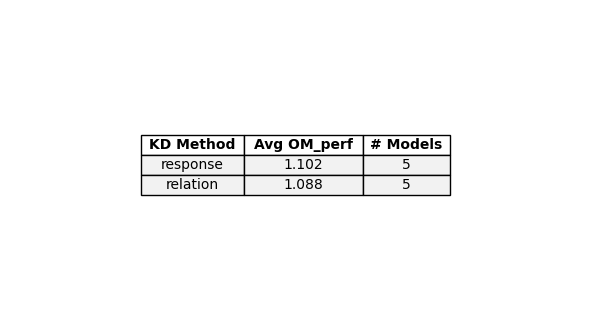

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------------------------------
# Build a nice compact table figure from df_summary
# ---------------------------------------------------

if "df_summary" not in globals():
    raise RuntimeError("df_summary not found. Run the OM_perf cell first.")

if df_summary.empty:
    raise RuntimeError("df_summary is empty. Check KD_GLOBS patterns and TEACHER_EVAL path.")

# We will visualize one row per KD_type,
# with a column for the average OM_perf value.
table_df = df_summary.copy()

# Rename columns for prettier table labels
table_df = table_df.rename(columns={
    "KD_type":     "KD Method",
    "OM_perf_avg": "Avg OM_perf",
    "n_models":    "# Models",
})

# Sort by Avg OM_perf (best on top)
table_df = table_df.sort_values("Avg OM_perf", ascending=False).reset_index(drop=True)

# Format Avg OM_perf nicely as string; keep others as-is
table_df["Avg OM_perf"] = table_df["Avg OM_perf"].map(
    lambda x: f"{x:.3f}" if pd.notnull(x) else "nan"
)

print("Table used for figure:")
display(table_df)

# ---------------------------------------------------
# Create matplotlib table (Pylance-friendly types)
# ---------------------------------------------------
# Convert to pure Python types that Pylance likes
cell_text: list[list[str]] = table_df.astype(str).to_numpy().tolist()
col_labels: list[str] = list(table_df.columns)

fig, ax = plt.subplots(figsize=(6, 1.2 * len(table_df) + 1))
ax.axis("off")

table = ax.table(
    cellText=cell_text,
    colLabels=col_labels,
    cellLoc="center",
    loc="center",
)

# Style header and body
for (row, col), cell in table.get_celld().items():
    if row == 0:
        # Header row
        cell.set_text_props(weight="bold", color="black")
        cell.set_facecolor("#ffffff")
    else:
        # Data rows
        cell.set_facecolor("#f2f2f2")

# Auto-resize columns
table.auto_set_column_width(col=list(range(table_df.shape[1])))

plt.tight_layout()

# High-quality saves
plt.savefig("OMperf_KD_summary_table.png", dpi=600, bbox_inches="tight")
plt.savefig("OMperf_KD_summary_table.pdf", bbox_inches="tight")

plt.show()


⚠️ No models found for KD type 'feature'. Skipping.


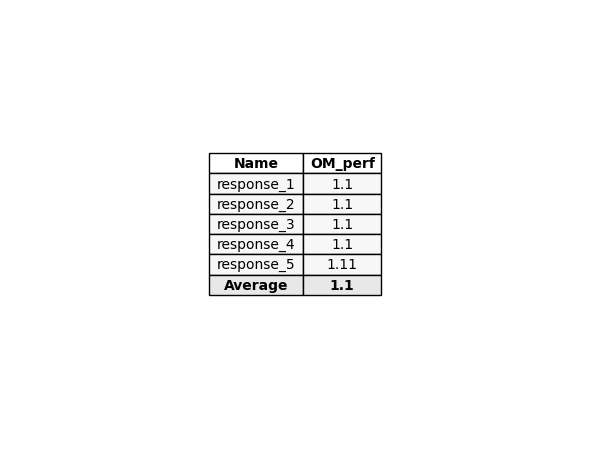

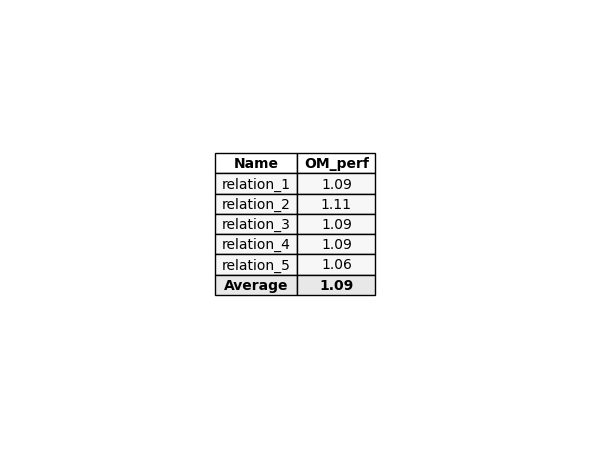

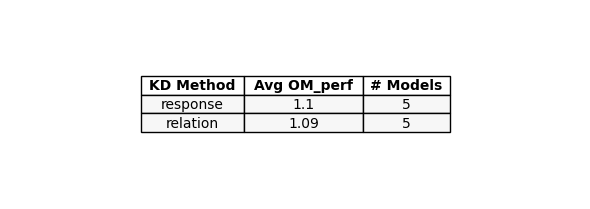

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import List

# ---------------------------------------------------
# KD TYPES TO PROCESS
# ---------------------------------------------------
KD_TAGS = ["feature", "response", "relation"]   # use all 3

if "df_models" not in globals():
    raise RuntimeError("df_models not found — run your OMperf 3-KD cell first.")


# ---------------------------------------------------
# Helper: make a pretty table figure
# ---------------------------------------------------
def make_table(clean_df: pd.DataFrame, filename: str, title: str = "", highlight_average: bool = True):
    fig, ax = plt.subplots(figsize=(6, len(clean_df)*0.6 + 1))
    ax.axis("off")

    # Pylance-safe conversion
    cell_text: List[List[str]] = clean_df.astype(str).to_numpy().tolist()
    col_labels: List[str] = list(clean_df.columns)

    table = ax.table(
        cellText=cell_text,
        colLabels=col_labels,
        cellLoc="center",
        loc="center"
    )

    # Styling
    has_name_col = "Name" in clean_df.columns

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight="bold")
            cell.set_facecolor("#ffffff")
        else:
            if highlight_average and has_name_col and clean_df.iloc[row-1]["Name"] == "Average":
                cell.set_facecolor("#e8e8e8")
                cell.set_text_props(weight="bold")
            else:
                cell.set_facecolor("#f7f7f7")

    table.auto_set_column_width(col=list(range(clean_df.shape[1])))

    plt.tight_layout()
    plt.savefig(filename + ".png", dpi=600, bbox_inches="tight")
    plt.savefig(filename + ".pdf", bbox_inches="tight")
    plt.show()


# ---------------------------------------------------
# Storage for combined summary
# ---------------------------------------------------
summary_rows = []


# ---------------------------------------------------
# Generate one table per KD type
# ---------------------------------------------------
for tag in KD_TAGS:

    subset = df_models[df_models["KD_type"] == tag].copy()
    if subset.empty:
        print(f"⚠️ No models found for KD type '{tag}'. Skipping.")
        continue

    # Detect OM_perf column
    om_col = None
    for c in subset.columns:
        if "om" in c.lower() and "ratio" not in c.lower():
            om_col = c
            break

    if om_col is None:
        raise ValueError("No OM_perf column found in df_models.")

    # Round OM_perf
    om_values = subset[om_col].round(2).tolist()
    names = [f"{tag}_{i+1}" for i in range(len(om_values))]

    clean_df = pd.DataFrame({
        "Name": names,
        "OM_perf": om_values
    })

    # Average row
    avg_val = round(clean_df["OM_perf"].mean(), 2)
    clean_df = pd.concat([
        clean_df,
        pd.DataFrame({"Name": ["Average"], "OM_perf": [avg_val]})
    ], ignore_index=True)

    # Save individual table (highlight average row)
    make_table(clean_df, f"OMperf_table_{tag}", title=f"{tag} KD", highlight_average=True)

    # Save for combined summary
    summary_rows.append({
        "KD_type": tag,
        "Avg_OM_perf": avg_val,
        "Num_Models": len(om_values)
    })


# ---------------------------------------------------
# Combined summary table for all 3 KD methods
# ---------------------------------------------------
summary_df = pd.DataFrame(summary_rows)

# Nice ordering
summary_df = summary_df[["KD_type", "Avg_OM_perf", "Num_Models"]]

# Convert to clean_df format (no Name column here)
cell_df = summary_df.rename(columns={
    "KD_type": "KD Method",
    "Avg_OM_perf": "Avg OM_perf",
    "Num_Models": "# Models"
})

# No average row to highlight here
make_table(cell_df, "OMperf_table_ALL", title="All KD Types Summary", highlight_average=False)
